[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana7/1_Manejo_de_portafolios_Markovitz.ipynb)

# Introducción

Trataremos de encontrar portafolios óptimos, utilizando como medidores la varianza de los retornos, así como el valor esperado de los retornos en un año (el valor que se espera ganar)

# Dependencias

In [1]:
# !pip install yfinance -U plotly

In [2]:
import yfinance as yf

import pandas as pd
import numpy as np

import cvxopt as opt

import plotly.express as px

# Datos


Los datos con los que trabajaremos son el precio de acciones de Google (GOOG), Apple (AAPL), IBM (IBM), Microsoft (MSFT) y ExxonMobil (XOM) del último año.

Para obtener los datos, usaremos [```yfinance```](https://github.com/ranaroussi/yfinance) y nos centraremos en el precio de cierre ajustado (Adj Close).

In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "GOOG AAPL IBM MSFT NFLX NVDA",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
data

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Date,,,,,,
2023-12-18,194.935013,136.698822,158.300018,369.884033,486.119995,50.062801
2023-12-19,195.979889,137.605576,157.152222,370.489502,495.019989,49.589939
2023-12-20,193.880188,139.159973,155.683426,367.869110,489.269989,48.097359
2023-12-21,193.730896,141.292328,156.393509,370.767426,491.609985,48.976116
2023-12-22,192.656174,142.209030,157.716400,371.799713,486.760010,48.816162
...,...,...,...,...,...,...
2024-12-11,246.490005,196.710007,230.119995,448.989990,936.559998,139.309998
2024-12-12,247.960007,193.630005,232.259995,449.559998,925.549988,137.339996
2024-12-13,248.130005,191.380005,230.820007,447.269989,918.869995,134.250000


<Axes: xlabel='Date'>

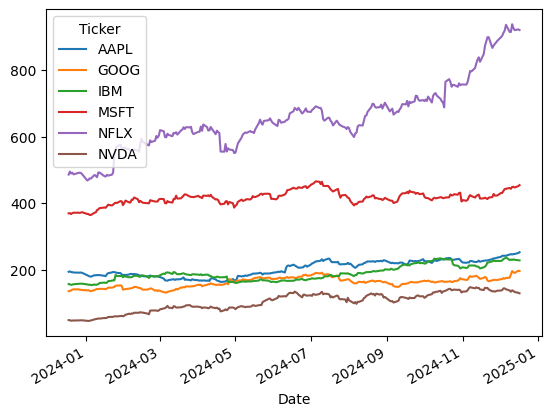

In [4]:
data.plot()

In [5]:
data.shift()

Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Date,,,,,,
2023-12-18,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-19,194.935013,136.698822,158.300018,369.884033,486.119995,50.062801
2023-12-20,195.979889,137.605576,157.152222,370.489502,495.019989,49.589939
2023-12-21,193.880188,139.159973,155.683426,367.869110,489.269989,48.097359
2023-12-22,193.730896,141.292328,156.393509,370.767426,491.609985,48.976116
...,...,...,...,...,...,...
2024-12-11,247.770004,186.529999,231.720001,443.329987,913.349976,135.070007
2024-12-12,246.490005,196.710007,230.119995,448.989990,936.559998,139.309998
2024-12-13,247.960007,193.630005,232.259995,449.559998,925.549988,137.339996


Obtenemos los retornos logarítmicos anualizados para cada activo.

In [6]:
annual_returns = np.log(data / data.shift()) * 252 # dias que tenemos en la data # Para anualizar los retornos
annual_returns

Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Date,,,,,,
2023-12-18,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-19,1.347144,1.666052,-1.833850,0.412165,4.571947,-2.391548
2023-12-20,-2.714460,2.830644,-2.366350,-1.788674,-2.944288,-7.701299
2023-12-21,-0.194120,3.832122,1.146776,1.977642,1.202349,4.562584
2023-12-22,-1.401862,1.629691,2.122636,0.700641,-2.498449,-0.824369
...,...,...,...,...,...,...
2024-12-11,-1.305226,13.390907,-1.746073,3.196925,6.323802,7.788925
2024-12-12,1.498398,-3.976925,2.332643,0.319719,-2.980012,-3.589002
2024-12-13,0.172709,-2.945411,-1.567236,-1.286940,-1.825360,-5.734472


In [11]:
annual_returns.iloc[0:125].mean()

,0
Ticker,
AAPL,0.210243
GOOG,0.540431
IBM,0.121230
MSFT,0.383342
NFLX,0.669601
NVDA,1.954244


In [12]:
annual_returns.iloc[125:252].mean()

,0
Ticker,
AAPL,0.315825
GOOG,0.198636
IBM,0.614019
MSFT,0.034311
NFLX,0.610130
NVDA,-0.008652


In [7]:
mean_returns = annual_returns.mean()
mean_returns

,0
Ticker,
AAPL,0.263665
GOOG,0.367491
IBM,0.370569
MSFT,0.206741
NFLX,0.639510
NVDA,0.961065


<Axes: xlabel='Date'>

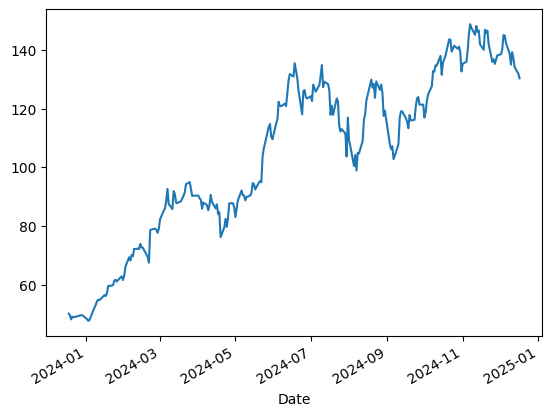

In [8]:
data.NVDA.plot()

In [13]:
cov_returns = annual_returns.cov()
cov_returns

Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Ticker,,,,,,
AAPL,12.614355,5.412734,1.393078,5.117178,4.851175,7.646066
GOOG,5.412734,18.877142,1.357457,7.615545,5.858888,10.990384
IBM,1.393078,1.357457,13.355249,3.010145,2.900675,5.265063
MSFT,5.117178,7.615545,3.010145,9.658792,5.802085,12.052377
NFLX,4.851175,5.858888,2.900675,5.802085,21.498133,17.257760
NVDA,7.646066,10.990384,5.265063,12.052377,17.257760,68.121438


In [14]:
mean_returns

,0
Ticker,
AAPL,0.263665
GOOG,0.367491
IBM,0.370569
MSFT,0.206741
NFLX,0.639510
NVDA,0.961065


In [16]:
omega = pd.Series([0.5, 0.1, 0.05, 0.15, 0.1, 0.1])*1000 # simulacion de inversion de 1000
omega

,0
0,500.0
1,100.0
2,50.0
3,150.0
4,100.0
5,100.0


In [19]:
np.dot(1 + mean_returns, omega) # el tiempo de datos historicos queda a criterio propio considerando la confianza que tenemos en el historico recordando
# el tema de la incertidumbre

1378.1786750198976

# Markovitz

https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html

Si $w$ es el vector de pesos de las acciones con retornos esperados $\mu$, entonces el retorno del portafolio es igual al peso de cada acción multiplicado por su retorno, es decir, $w^T \mu$. El riesgo del portafolio en términos de la matriz de covarianzas $\Sigma$ esta dado por $\sigma^2 = w^T \Sigma w$.

Lo cual, un poco mas "desmenuzado", es lo escrito en los 2 siguientes cuadros de texto.



## Valor esperado de portafolio comparado con valor esperado de cada activo

Tengo 4 activos y un capital de $v_0$ pesos:
- cada activo tiene su retorno esperado $\mu_1, \, \mu_2, \, \mu_3, \, \mu_4 $
- a cada activo le invierto $w_1, \, w_2, \, w_3, \, w_4 $ ( son tales que $w_1 + w_2 + w_3 +  w_4 = v_0$)

Entonces:

$ \operatorname{E}(R_p) = \sum_i w_i \operatorname{E}(R_i) = \sum_i w_i \mu_i \quad $


## Volatilidad esperada de portafolio comparado con volatilidad de cada activo

- cada activo tiene una volatilida $\sigma_1, \, \sigma_2, \, \sigma_3, \, \sigma_4 $ respectivamente. Entonces la volatilidad del portafolio es:

$ \sigma_p^2 = \sum_i w_i^2 \sigma_{i}^2 + \sum_i \sum_{j \neq i} w_i w_j \sigma_i \sigma_j \rho_{ij} $,

donde $\sigma_i$ es la volatilidad de cada activo y $\rho_{ij}$ es el coeficiente de correlación de los retornos del activo $i$ con el activo $j$.

- En esto puede haber correlación negativa entre activos, lo cual puede mitigar el riesgo, por ende aumentar más activos, no necesario incrementa el riesgo

La razón de Sharpe es el retorno en exceso del portafolio por unidad de riesgo (volatilidad)

$$
SR = \frac{R_p-R_f}{\sigma}
$$

retorno de portfolio y restarle portafolio seguro

Con esto en mente, crearemos un cantidad $N$ de portafolios con pesos aleatorios y guardaremos tanto los pesos, como el retorno, la volatilidad y la razon de Sharpe para cada uno.

--------------------------------------------
*NOTA**: Los comentarios en los siguientes 2 bloques de código son para que al quitarlo veamos los portafolios PUROS (todo el capital a una sola acción)
--------------------------------------------
_____________________________________________



Si dejan los comentarios -> obtienen las 10,000 muestras

Si quitan los comentarios -> ¿que obtienen? ________________

In [40]:
np.random.seed(1995)

N = 10000
#N = 6  ## para tener un portafolio puro donde se invierte en una sola accion

k = annual_returns.shape[1]

weights = np.zeros((N, k))
returns = np.zeros(N)
volatilities = np.zeros(N)
sharpe_ratios = np.zeros(N)

weights2 = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]) # ## para tener un portafolio puro donde se invierte en una sola accion

weights.shape

(10000, 6)

In [41]:
weights

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [43]:
w = np.random.random(6) # portfolio al azar con porcentajes del portfolio con variables aleatorias normales
w /= np.sum(w)
w

array([0.09248761, 0.26057282, 0.15210978, 0.27501385, 0.06585835,
       0.15395759])

In [44]:
for i in range(N):
    w = np.random.random(k)
    w /= np.sum(w)

   # w = weights2[i]  ##   ## para tener un portafolio puro donde se invierte en una sola accion
   # weights[i, :] = weights2[i]  ##  ## para tener un portafolio puro donde se invierte en una sola accion

    weights[i, :] = w

    returns[i] = np.dot(mean_returns, w)

    volatilities[i] = np.sqrt(np.dot(w.T, np.dot(cov_returns, w)))         ###        w.T @ cov_returns @ w

    sharpe_ratios[i] = returns[i] / volatilities[i]

In [45]:
weights

array([[0.23176348, 0.25672011, 0.05838959, 0.21149406, 0.23724876,
        0.00438401],
       [0.39789683, 0.09166851, 0.2506735 , 0.11003303, 0.10273552,
        0.0469926 ],
       [0.08622008, 0.15460911, 0.16012943, 0.18122302, 0.20754228,
        0.21027608],
       ...,
       [0.18326347, 0.30669843, 0.10277785, 0.04338749, 0.02795858,
        0.33591417],
       [0.24431589, 0.23067893, 0.24063098, 0.17955388, 0.00376932,
        0.101051  ],
       [0.1589712 , 0.05137859, 0.20937183, 0.22125611, 0.24760583,
        0.11141643]])

In [46]:
weights[7]

array([0.23113517, 0.22144064, 0.00418051, 0.22525852, 0.16539082,
       0.15259434])

In [47]:
returns[7]

0.44286113620098455

In [48]:
volatilities[7]

3.2166081683734844

Graficamos la volatilidad contra el retorno de cada portafolio generado y coloreamos en función de la razón de Sharpe. Los portafolios (casi) óptimos, serían aquellos que tienen el mayor retorno para cierto nivel de volatilidad, o dicho de otra manera, los que tienen la menor volatilidad para algún retorno especificado.

In [49]:
# Portafolios puros
import matplotlib.pyplot as plt

px.scatter(x = volatilities, y = returns, color = sharpe_ratios,
           labels={
                     "x": "Volatilidad",
                     "y": "Retorno",
                     "color": "Razón de Sharpe"
                 }
           )
# plt.scatter(volatilities, returns, c = sharpe_ratios)

In [51]:
import matplotlib.pyplot as plt

px.scatter(x = volatilities, y = returns, color = sharpe_ratios,
           labels={
                     "x": "Volatilidad",
                     "y": "Retorno",
                     "color": "Razón de Sharpe"
                 }
           )
# plt.scatter(volatilities, returns, c = sharpe_ratios)
# de verse vertical, el mejor portafolio es el que este mas arriba ya que implica mas rendimiento para la misma volayilidad
# de verse horizontal, el mejor portafolio es el que este mas a la izquierda meaning menos volatilidad por misma retorno
# para esto sirve la razon de sharpe retorno / volatilidad, donde mas grande esta razon, implica mas retorno sobre volatilidad

> La optimización del portafolio se puede ver como un problema de optimización convexa y una solución puede encontrarse usando programación cuadrática. Si denotamos el retorno objetivo como $\mu^*$, el problema a resolver para el portafolio sólo con posiciones largas es:

\begin{align}
    \text{min}_w && w^T \Sigma w \\
    \text{s.a.} && w^t \mu \geq \mu^*  \\
    && w^T \mathbf{1} = 1 \\
    && w_i \geq 0
\end{align}

Para resolverlo, ocuparemos la función [```covxopt.solvers.qp```](https://cvxopt.org/userguide/coneprog.html#quadratic-programming). Esta requiere que el problema de optimización se encuentre en la forma general. A saber, la forma general de un problema de programación cuadrática es la siguiente:

\begin{align}
    \text{min}_x && \frac{1}{2}x^TPx + q^Tx \\
    \text{s.a.} && Gx \preceq h \\
    && Ax = b
\end{align}

In [ ]:
mu_star = 0.5

In [ ]:
G = opt.matrix(-np.concatenate([mean_returns.to_numpy().reshape(1, k),np.eye(k)]), tc = 'd')
h = opt.matrix(np.concatenate([np.array([-mu_star]).reshape((1, 1)), np.zeros((k, 1))]), tc = 'd')
q = opt.matrix(0.0, (k, 1))
A = opt.matrix(1.0, (1, k))
b = opt.matrix(1.0)
P = opt.matrix(2 * cov_returns.to_numpy(), tc = 'd')

In [ ]:
results = opt.solvers.qp(P, q, G, h, A, b)
results

     pcost       dcost       gap    pres   dres
 0:  5.1141e+00  4.4914e+00  1e+01  3e+00  5e+00
 1:  5.1615e+00  4.9447e+00  2e+00  7e-01  1e+00
 2:  1.1094e+01  7.3459e+00  8e+00  3e-01  4e-01
 3:  8.7813e+00  8.1881e+00  6e-01  1e-16  2e-14
 4:  8.3863e+00  8.3565e+00  3e-02  2e-16  8e-15
 5:  8.3630e+00  8.3627e+00  3e-04  1e-16  4e-15
 6:  8.3628e+00  8.3628e+00  3e-06  2e-16  1e-15
Optimal solution found.


{'x': <6x1 matrix, tc='d'>,
 'y': <1x1 matrix, tc='d'>,
 's': <7x1 matrix, tc='d'>,
 'z': <7x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 3.0178076986190323e-06,
 'relative gap': 3.6086163204593895e-07,
 'primal objective': 8.362786507726778,
 'dual objective': 8.36278348991908,
 'primal infeasibility': 2.2388688230491736e-16,
 'dual infeasibility': 1.3803799860169535e-15,
 'primal slack': 1.015436842754076e-07,
 'dual slack': 2.1238671255983237e-07,
 'iterations': 6}

Los pesos del portafolio óptimo los obtenemos de la llave ```x```

In [ ]:
# impresion bonita de los numeros decimales
np.set_printoptions(suppress=True)

In [ ]:
w = np.asarray(results['x']).reshape((-1))
w

array([0.01199571, 0.11976473, 0.50698453, 0.05186462, 0.15790662,
       0.1514838 ])

In [ ]:
mean_returns

Ticker
AAPL    0.104825
GOOG    0.356563
IBM     0.350954
MSFT    0.298525
NFLX    0.585805
NVDA    1.123060
dtype: float64

In [ ]:
# PORTAFOLIO ARRIESGADO, 0.5
np.dot(mean_returns, w)

0.5000001015436842

La volatilidad de ```primal objective```

In [ ]:
np.sqrt(results['primal objective'])

2.8918482857381673

In [ ]:
# PORTAFOLIO ARRIESGADO, mu_estrella es 0.1
np.dot(mean_returns, w)

0.5000001015436842

In [ ]:
np.sqrt(results['primal objective'])

2.8918482857381673

Si variamos los retornos objetivos, podemos obtener la **Frontera Eficiente**, que esta constituida de los portafolios óptimos para distintos niveles del retorno.

In [ ]:
mu_stars = np.linspace(.0, .6, 51)
mu_stars

array([0.   , 0.012, 0.024, 0.036, 0.048, 0.06 , 0.072, 0.084, 0.096,
       0.108, 0.12 , 0.132, 0.144, 0.156, 0.168, 0.18 , 0.192, 0.204,
       0.216, 0.228, 0.24 , 0.252, 0.264, 0.276, 0.288, 0.3  , 0.312,
       0.324, 0.336, 0.348, 0.36 , 0.372, 0.384, 0.396, 0.408, 0.42 ,
       0.432, 0.444, 0.456, 0.468, 0.48 , 0.492, 0.504, 0.516, 0.528,
       0.54 , 0.552, 0.564, 0.576, 0.588, 0.6  ])

In [ ]:
G = opt.matrix(-np.concatenate([mean_returns.to_numpy().reshape(1, k),np.eye(k)]), tc = 'd')
q = opt.matrix(0.0, (k, 1))
A = opt.matrix(1.0, (1, k))
b = opt.matrix(1.0)
P = opt.matrix(2 * cov_returns.to_numpy(), tc = 'd')

mu_stars = np.linspace(.0, .6, 51)    #####################

ws = np.zeros((len(mu_stars), k))
mus = np.zeros(len(mu_stars))
sigmas = np.zeros(len(mu_stars))

for i, mu_star in enumerate(mu_stars):
    try:
        h = opt.matrix(np.concatenate([np.array([-mu_star]).reshape((1, 1)), np.zeros((k, 1))]), tc = 'd')
        results = opt.solvers.qp(P, q, G, h, A, b)

        w = np.asarray(results['x']).reshape((-1))
        ws[i, :] = w
        mus[i] = np.dot(mean_returns, w)
        sigmas[i] = np.sqrt(results['primal objective'])
    except:
        print('domain error')

     pcost       dcost       gap    pres   dres
 0:  5.1118e+00  3.7788e+00  1e+01  3e+00  5e+00
 1:  5.1294e+00  4.2490e+00  1e+00  2e-01  3e-01
 2:  5.4667e+00  4.9880e+00  5e-01  2e-16  5e-15
 3:  5.2944e+00  5.2560e+00  4e-02  2e-16  7e-15
 4:  5.2691e+00  5.2684e+00  7e-04  1e-16  3e-15
 5:  5.2686e+00  5.2686e+00  7e-06  1e-16  3e-15
 6:  5.2686e+00  5.2686e+00  7e-08  1e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.1119e+00  3.7901e+00  1e+01  3e+00  5e+00
 1:  5.1298e+00  4.2537e+00  1e+00  2e-01  3e-01
 2:  5.4657e+00  4.9898e+00  5e-01  1e-16  2e-15
 3:  5.2942e+00  5.2561e+00  4e-02  1e-16  4e-15
 4:  5.2691e+00  5.2684e+00  6e-04  2e-16  3e-15
 5:  5.2686e+00  5.2686e+00  6e-06  1e-16  3e-15
 6:  5.2686e+00  5.2686e+00  6e-08  1e-16  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.1119e+00  3.8017e+00  1e+01  3e+00  5e+00
 1:  5.1302e+00  4.2587e+00  1e+00  2e-01  3e-01
 2:  5.4647e+00  4.9916e

Finalmente, podemos graficar la frontera eficiente. Se puede observar que, pese a que las simulaciones nos dieron portafolios a la frontera, no eran realmente óptimos.

In [ ]:
mus[-3:]

array([0.57600001, 0.58800002, 0.60000002])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_traces(
    [
        go.Scatter(
            x = volatilities, y = returns,
            marker = dict(
                color = sharpe_ratios,
                colorbar = dict(title="Razón de Sharpe")
            ),
            mode = 'markers',
            showlegend = False
        ),
        go.Scatter(
            x = sigmas, y = mus,
            mode = 'lines + markers',
            showlegend = False
        )
])

fig.update_layout(
    xaxis_title = 'Volatilidad',
    yaxis_title = 'Retorno'
)



Notas

1. Se están usando los retornos sin considerar la tasa libre de riesgo.

Ejercicios

1. Encontrar y graficar el portafolio óptimo de acuerdo a la razón de Sharpee
2. Agregar los puntos de los portafolios que contienen únicamente un activo
3. Encontrar el portafolio con la menor volatilidad
4. Restar la tasa libre de riesgo a los retornos

# Mean-Variance Choice

El portafolio óptimo también se podría obtener maximizando, respecto a $w$,

$$
U(\mu, \Sigma; w) = w^T\mu - \frac{\delta}{2}w^T\Sigma w
$$

donde $\delta > 0$ es el parámetro de aversión al riesgo. La condición de primer orden para maximizarla es

$$
\mu = \delta \Sigma w
$$

lo que implica el siguiente diseño para un portafolio con riesgo:

$$
w = \left( \delta \Sigma \right)^{-1} \mu
$$

Es un sistema de ecuaciones lineales que podemos resolver con [```np.linalg.solve```](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html).

In [ ]:
delta = .2

np.linalg.solve(delta * cov_returns,  mean_returns)

array([-0.06629797,  0.03347792,  0.13145856, -0.0246617 ,  0.06104751,
        0.07911545])

In [ ]:
data.columns

Index(['AAPL', 'GOOG', 'IBM', 'MSFT', 'NFLX', 'NVDA'], dtype='object', name='Ticker')

# Ligas interesantes

1. https://python-advanced.quantecon.org/black_litterman.html